In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle
import kipoiseq
from itertools import combinations
import scipy
import os
import gene as bgene
import shuffle
from scipy.stats import pearsonr

2024-01-14 13:06:34.252117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# best_tiles = []
# bad_counter = 0
# for cell in ['PC-3', 'GM12878', 'K562']:
#     for f in glob.glob(f'../results/motifs_1000/{cell}/*'):
#         res = utils.read_pickle(f)
#         if 1000 in res.keys():
#             best_tiles.append(np.max(res[1000].mean(axis=0) / res['pred_mut']))
#         else:
#             bad_counter += 1
#     sns.histplot(best_tiles)
#     plt.title(cell)
#     plt.show()

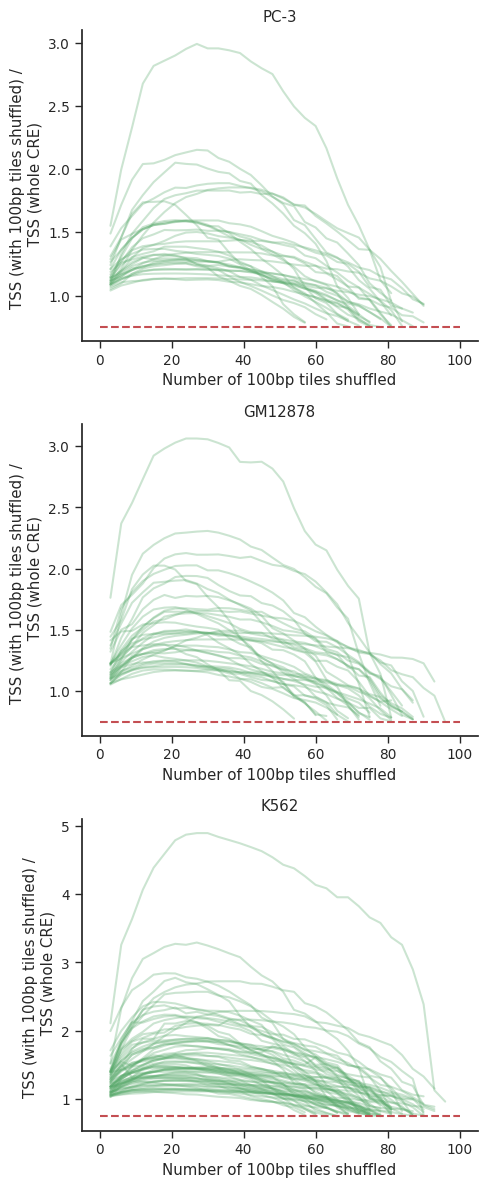

In [3]:
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/motif_level/')

result_dir = '../results/motifs_100_batch_3_shuffle_10_thresh_0.75'
threshold = float(result_dir.split('_')[-1])

sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, axes = plt.subplots(3, 1, sharey=False, figsize=[5, 12]) 

for i, cell in enumerate(os.listdir(result_dir)):
    ax = axes[i]
    result_files = glob.glob(f'{result_dir}/{cell}/*pickle')
    for res_path in result_files:
        per_seq_results = utils.read_pickle(res_path)
        if 'fraction_explained' in per_seq_results.keys():
            frac_explained = per_seq_results['fraction_explained'][:-1]
            ax.plot(np.arange(3, 3*len(frac_explained)+1, 3), frac_explained, alpha=0.3, color='g')
    ax.hlines(threshold, 0, 100, color='r', linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(cell)
    ax.set_xlabel('Number of 100bp tiles shuffled')
    ax.set_ylabel('TSS (with 100bp tiles shuffled) / \n TSS (whole CRE)')
    plt.tight_layout()
    fig.savefig(f'{pdf_dir}/{result_dir.split("/")[-1]}.pdf', format='pdf', dpi=300, bbox_inches='tight')
        

In [14]:
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/motif_level/')

result_dir = '../results/motifs_500,50_batch_1,10_shuffle_10_thresh_0.9,0.7/'
thresholds = [float(i) for i in result_dir.split('_')[-1].split('/')[0].split(',')]
thresholds


[0.9, 0.7]

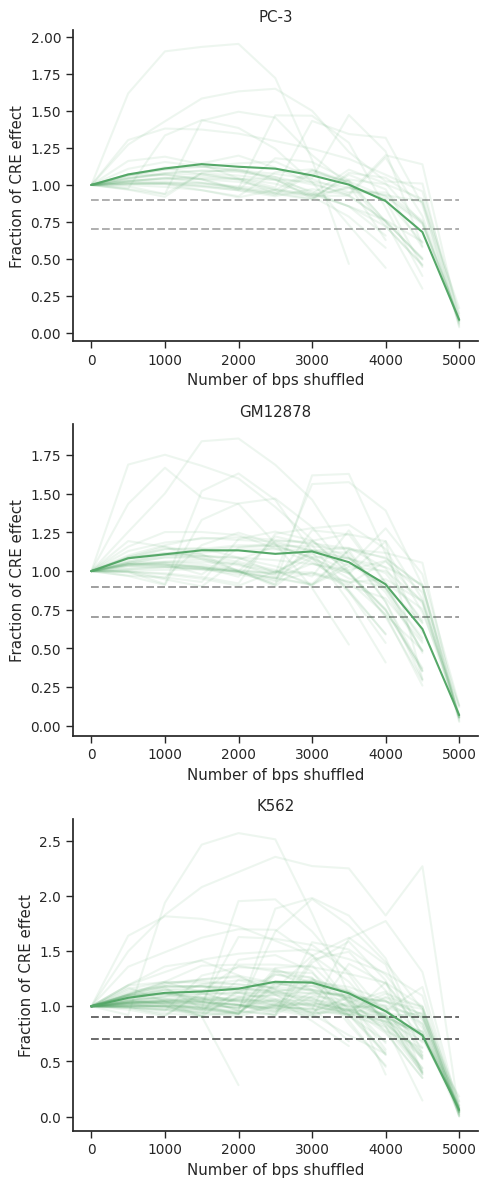

In [104]:
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, axes = plt.subplots(3, 1, sharey=False, figsize=[5, 12]) 

for i, cell in enumerate(os.listdir(result_dir)):
    average_line = []
    average_bps = []
    ax = axes[i]
    result_files = glob.glob(f'{result_dir}/{cell}/*pickle')
    for res_path in result_files:
        
        per_seq_results = utils.read_pickle(res_path)
        if 500 in per_seq_results.keys():
            bps = np.array([5000-int(i) for i in [5000] + per_seq_results[500]['bps'][:-1] + per_seq_results[50]['bps']])
            average_bps.append(bps)
            frac = np.array([1] + per_seq_results[500]['scores'][:-1] + per_seq_results[50]['scores'])
            ax.plot(bps, frac, color='g', alpha=0.1)
            ax.hlines(0.9, 0, 5000, alpha=0.01, color='k', linestyles='--', label='threshold 1')
            ax.hlines(0.7, 0, 5000, alpha=0.01, color='k', linestyles='--', label='threshold 2')
            average_line.append(frac)
    longest_i = np.argmax([len(l) for l in average_line])
    
    average_bps = average_bps[longest_i]

    average_line = np.array([np.pad(a, mode='constant',constant_values=(np.nan,), pad_width=(0, len(average_line[longest_i])-len(a))) for a in average_line])
    average_line = np.nanmean(average_line, axis=0)
    ax.plot(average_bps, average_line, color='g', alpha=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Number of bps shuffled')
    ax.set_ylabel('Fraction of CRE effect')
    ax.set_title(cell)

plt.tight_layout()


# XSTREME

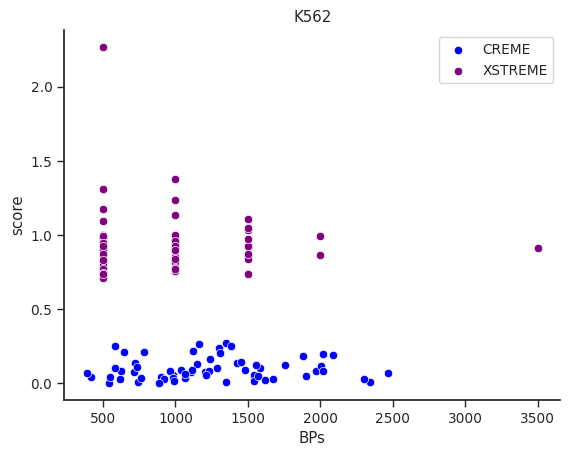

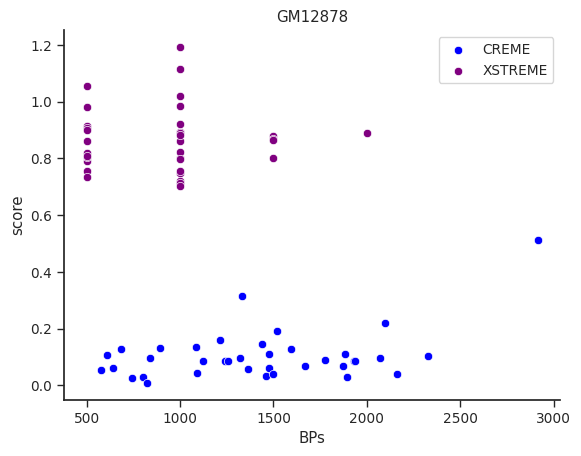

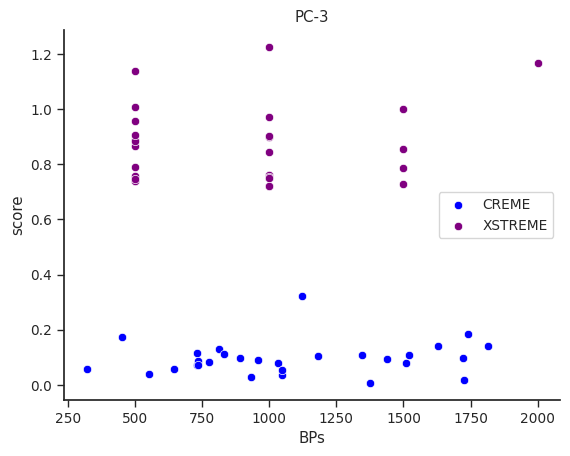

In [208]:
for cell_line in ['K562', 'GM12878', 'PC-3']:
    result_paths = glob.glob(f'../results/XSTREME/FIMO/{cell_line}_enhancers_*//*pickle')
    my_scores = []
    my_bps = []
    xstreme_scores = []
    xstreme_bps = []
    for res_path in result_paths:
        res = utils.read_pickle(res_path)
        prune_res = utils.read_pickle(f"../results/motifs_500,50_batch_1,10_shuffle_10_thresh_0.9,0.7/{cell_line}/{res_path.split('/')[-1]}")
        xstreme_scores.append(res['motifs'] / prune_res['mut'])
        xstreme_bps.append(np.sum(res['motif_mask']))
        if len(prune_res[50]['scores']) > 1:
            my_scores.append(prune_res[50]['scores'][-2])
            my_bps.append(prune_res[50]['bps'][-2])
        else:
            my_scores.append(prune_res[500]['scores'][-2])
            my_bps.append(prune_res[500]['bps'][-2])
    ax=sns.scatterplot(x=xstreme_bps, y=xstreme_scores, color='blue', label='CREME')
    ax=sns.scatterplot(x=my_bps, y=my_scores, color='purple', label='XSTREME')
    plt.xlabel('BPs')
    plt.ylabel('score')
    ax.set_title(cell_line)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

In [333]:
tile_coords = res_path.split('/')[-1].split('_')[-2:]
tile_start = int(tile_coords[0])
tile_end = int(tile_coords[1].split('.')[0])

In [338]:
seq_parser = utils.SequenceParser('../data/GRCh38.primary_assembly.genome.fa')
wt_seq = seq_parser.extract_seq_centered('chr16', 4795368, '+', model.seq_length)


In [339]:
wt_seq.shape

(196608, 4)

In [340]:
wt_seq_padded = np.pad(wt_seq[np.newaxis].copy(), ((0, 0), (model.seq_length // 2, model.seq_length // 2), (0, 0)), 'constant')

In [341]:
control_sequences = prune_res['control_sequences']

In [311]:
model = custom_model.Enformer(track_index=4824, bin_index=[447, 448])

In [223]:
creme_mask = np.zeros((5000,))
for x in prune_res[50]['insert_coords']:
    creme_mask[x[0]-100804: x[1]-100804] = 1

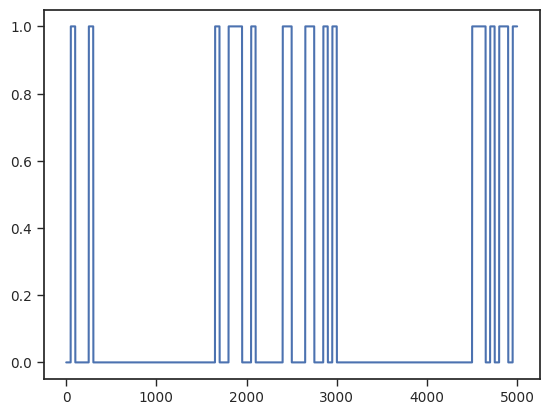

In [224]:
plt.plot(creme_mask)

In [312]:
model = custom_model.Enformer()

In [196]:
predictions = model.predict(wt_seq[np.newaxis])[0]


In [197]:
target_mask = np.zeros_like(predictions)
for idx in [447, 448]:
  target_mask[idx, 4824] = 1


In [259]:
saliency = model.contribution_input_grad(wt_seq_padded, target_mask)[model.seq_length//2:-model.seq_length//2]

In [260]:
cre_saliency_scores = saliency[100804:105804]

In [374]:
bps = np.array([5000-int(i) for i in [5000] + prune_res[500]['bps'][:-1] + prune_res[50]['bps']])
frac = np.array([1] + prune_res[500]['scores'][:-1] + prune_res[50]['scores'])

sal_preds = []
random_preds = []
for bp in bps:
    worst_saliency_positions = [l+tile_start for l in np.argsort(np.abs(cre_saliency_scores))[:bp]]
    random_pos = [l+tile_start for l in np.random.choice(list(range(5000)), bp, replace=False)]

    # for label, mask in {'saliency': worst_saliency_positions, 'random': random_pos}    
    remove_saliency_based = control_sequences.copy()
    remove_saliency_based[:, tile_start: tile_end, :] = wt_seq[tile_start:tile_end].copy()
    remove_saliency_based[:,worst_saliency_positions,:] = control_sequences[:,worst_saliency_positions,:].copy()

    
    remove_random = control_sequences.copy()
    
    remove_random[:, tile_start:tile_end, :] = wt_seq[tile_start:tile_end].copy()
    remove_random[:, random_pos, :] = control_sequences[:, random_pos,:].copy()
    
    sal_preds.append(model.predict(remove_saliency_based)[:, [447, 448], 4824].mean() / prune_res['mut'])
    random_preds.append(model.predict(remove_random)[:, [447, 448], 4824].mean() / prune_res['mut'])

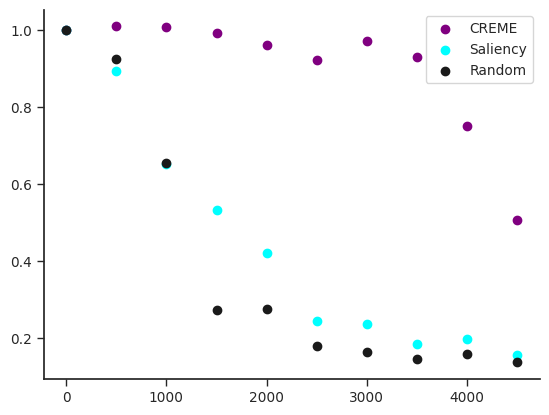

In [375]:
fig, ax = plt.subplots(1)

ax.scatter(bps, frac, color='purple', label='CREME')
ax.scatter(bps, sal_preds, color='cyan', label='Saliency')
ax.scatter(bps, random_preds, color='k', label='Random')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()

In [388]:
res_path

'../results/XSTREME/FIMO/PC-3_enhancers_4824/SMIM22_chr16_4795368_+_100804_105804.pickle'

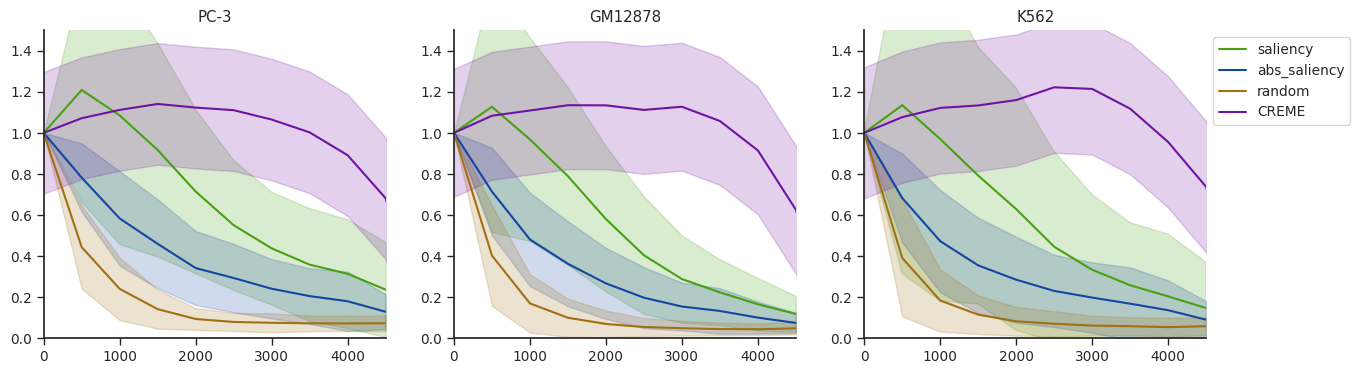

In [477]:
fig, axes = plt.subplots(1, 3, figsize=[15, 4])
for a, (index, cell_line) in enumerate({4824: 'PC-3', 5110: 'GM12878', 5111: 'K562'}.items()):
    ax = axes[a]
    bps = np.arange(0, 5000, 500)
    mean_set = {k:[] for k in saliency_res.keys()}
    mean_set_CREME = []
    for s, seq_tile_id in enumerate(os.listdir(f'../results/saliency/{index}/')): 
        saliency_res = utils.read_pickle(f'../results/saliency/{index}/{seq_tile_id}')
        prune_res = utils.read_pickle(f'../results/motifs_500,50_batch_1,10_shuffle_10_thresh_0.9,0.7/{cell_line}/{seq_tile_id}')
        prune_bps = np.array([5000-int(i) for i in [5000] + prune_res[500]['bps'][:-1] + prune_res[50]['bps']])
    
        frac = np.array([1] + prune_res[500]['scores'][:-1] + prune_res[50]['scores'])
        c = ['#46a114', '#1446a1', '#a16f14']
        for i, (label, scores) in enumerate(saliency_res.items()):
            norm_scores = np.array(scores)/prune_res['mut']
            # plt.scatter(bps, norm_scores, label=label)

            # ax.plot(bps, norm_scores, alpha=0.08, color=c[i])
            mean_set[label].append(norm_scores)
        
        
        # plt.scatter(prune_bps, frac, color='#6f14a1')
        # ax.plot(prune_bps, frac, alpha=0.1, color='#6f14a1')
        mean_set_CREME.append(frac)
        
    longest_i = np.argmax([len(l) for l in mean_set_CREME])

    mean_set_CREME = np.array([np.pad(a, mode='constant',constant_values=(np.nan,),
                                      pad_width=(0, len(mean_set_CREME[longest_i])-len(a))) for a in mean_set_CREME])
    mean_set_CREME = np.nanmean(mean_set_CREME, axis=0)
    std_set_CREME = np.nanstd(mean_set_CREME, axis=0)

    for j, (k, v) in enumerate(mean_set.items()):
        mean = np.array(v).mean(axis=0)
        std = np.array(v).std(axis=0)
        ax.fill_between(bps, mean-std, mean+std, color=c[j], alpha=.2)
        ax.plot(bps, np.array(v).mean(axis=0), label=k, color=c[j])


    
    ax.plot(np.arange(0, 5500, 500), mean_set_CREME, label='CREME', color='#6f14a1')
    ax.fill_between(np.arange(0, 5500, 500), mean_set_CREME-std_set_CREME, mean_set_CREME+std_set_CREME, color='#6f14a1', alpha=.2)
    if a==2:
        ax.legend(bbox_to_anchor=[1,1])
    ax.set_title(cell_line)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(0, 4500)
    ax.set_ylim(0, 1.5)
    
    


In [463]:
len(mean_set_CREME)

11

In [465]:
bps

array([   0,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500])

In [449]:
np.array(mean_set['saliency']).mean(axis=0)

(63, 10)

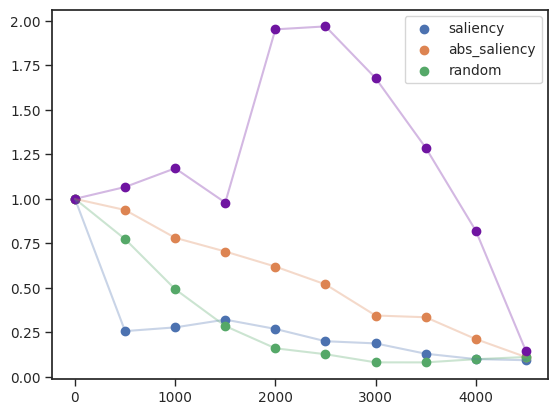

In [399]:
frac = np.array([1] + prune_res[500]['scores'][:-1] + prune_res[50]['scores'])


In [400]:
frac

array([1.        , 1.0484935 , 1.07185853, 1.07260752, 1.04365623,
       1.00844395, 0.93911999, 1.10360038, 1.01002669, 0.7392596 ,
       0.09941151])

105.24791